In [475]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def zscore(series):
    return (series - series.mean()) / series.std()

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid(x, k=1, x0=0):
    return 1 / (1 + np.exp(-k * (x - x0)))

def adjusted_sigmoid(x, f_min=0.01, f_max=0.1, k=1, x0=0):
    return f_min + (f_max - f_min) * sigmoid(x, k=k, x0=x0)

def global_sigmoid(x, f_min, f_max, k=1, x0=0):
    if x > 0:
        return adjusted_sigmoid(x, f_min, f_max, k, x0)
    else:
        return adjusted_sigmoid(-x, f_min, f_max, k, x0)


data = pd.read_pickle('data/Merged_CEX_DEX_v2_p1.pkl')
data.head()

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,price_dex,tcost_usd,time,time_dex,price_cex,time_cex,LVR_clean,LVR_clean_cumm,LVR,LVR_cumm
0,18096.796543,-7.930474,18076.269412,0xe743a49f04f2f77eb2d3b753ae3ad599de8cea84,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x4fd39c9e151e50580779bd04b1f7ecc310079fd3,1.704067e+09,427523,1.358341e+10,1.358341e-08,...,2280.878682,13.245562,2024-01-01 00:00:23,2024-01-01 00:00:23,2281.19,2024-01-01 00:00:12.962,0.311318,0.311318,-2.468898,2.468898
1,700.000000,-0.306764,699.212694,0xa1179a0b94e53ee82b77c6d24c2cf67a656c2503,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704067e+09,312000,1.438341e+10,1.438341e-08,...,2280.878682,10.235724,2024-01-01 00:00:23,2024-01-01 00:00:23,2281.19,2024-01-01 00:00:12.962,0.311318,0.622636,-0.095501,2.564399
2,25000.000000,-10.955150,24971.093893,0x9b4306e7b6ede125b5e8cac309ffb58af5eed6f0,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704067e+09,223193,1.259051e+10,1.259051e-08,...,2281.106770,6.410172,2024-01-01 00:00:47,2024-01-01 00:00:47,2282.69,2024-01-01 00:00:35.850,1.583230,2.205866,-17.344522,19.908921
3,767.722283,-0.336412,766.824534,0xc10527cdbc055b7f9a8a4ad765b287190c861c51,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704067e+09,247124,1.230578e+10,1.230578e-08,...,2281.106770,6.936970,2024-01-01 00:00:59,2024-01-01 00:00:59,2282.69,2024-01-01 00:00:35.850,1.583230,3.789096,-0.532617,20.441538
4,170.905965,-0.074890,170.706032,0xf468072ca8f81e11655c252a37317e814b24872b,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0xa9cffe466ba8a72707d1104de239c9ab477e2493,1.704067e+09,2673946,1.443436e+10,1.443436e-08,...,2281.106770,88.043187,2024-01-01 00:01:23,2024-01-01 00:01:23,2281.64,2024-01-01 00:01:08.214,0.533230,4.322326,-0.039934,20.481472


In [476]:
(data[data['LVR_clean']>data['LVR_clean'].quantile(0.9)]['tcost_usd']/data[data['LVR_clean']>data['LVR_clean'].quantile(0.9)]['amountUSD'])

2        0.000257
3        0.009046
13       0.000116
14       0.003482
15       0.007295
           ...   
59959    0.001452
59961    0.005187
59978    0.818687
59979    0.000445
59980    0.312736
Length: 6000, dtype: float64

<Axes: >

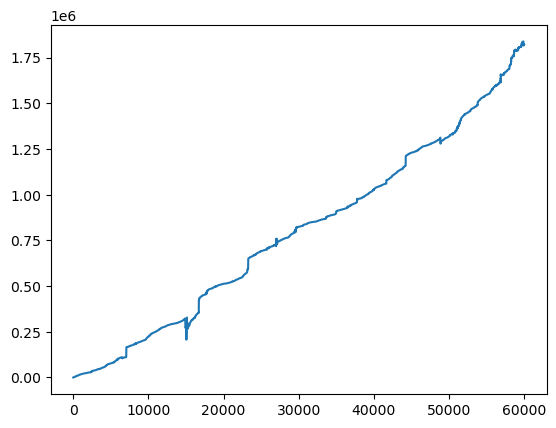

In [477]:
# fees received by LP in USD
# if amount0>0, it is added to the pool and if amount1<0, it is taken from the pool.
fee_receive_quote = data.amount0 + data.amount1 * data.price_dex.shift(1)
fee_receive_quote.cumsum().plot()

<Axes: >

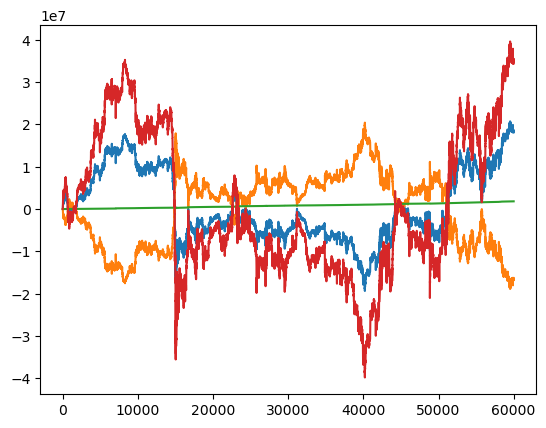

In [478]:
data.amount0.cumsum().plot()
(data.amount1 * data.price_dex.shift(1)).cumsum().plot()
(data.amount0 + data.amount1 * data.price_dex.shift(1)).cumsum().plot()
(data.amount0 - data.amount1 * data.price_dex.shift(1)).cumsum().plot()

<Axes: >

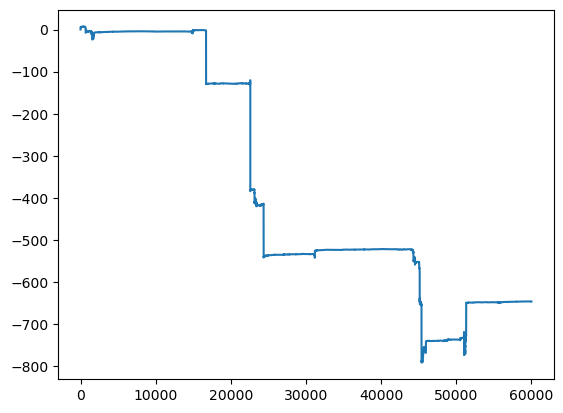

In [479]:
(data.amount0  + data.amount0 ).cumsum().pct_change().cumsum().plot()

<Axes: >

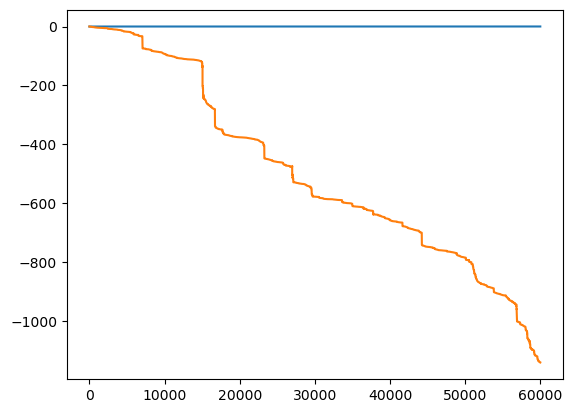

In [480]:
ret_token1 = data.price_dex.pct_change(1)#.shift(1)
ret_pool   = ret_token1 * data.amount1
ret_pool.dropna()

ret_token1.cumsum().plot()
ret_pool.cumsum().plot()

In [481]:
data['time'] = pd.to_datetime(data['time'])
data = data.sort_values('time')

data['impermanent_loss'] = (2 * np.sqrt(data['price_dex'].shift(1) / data['price_dex']) / (1 + data['price_dex'].shift(1) / data['price_dex']) - 1).fillna(0)

data['LVR_nbtoken']     = data['LVR']/data['price_dex']

data['avg_gas'] = data['gasUsed'] * data['gasPrice_eth'].rolling(100).mean() * data['price_dex']

data['arb_fee']    = (np.abs(data['LVR_clean'] * data['amountUSD']) - (data['tcost_usd'] - data['avg_gas']))*100 / data['amountUSD']
data['LVR_zscore'] = zscore(data['LVR']) #.clip(-3, 3)


data['std']             = data['price_dex'].rolling(100).std()
data['mean_rol_amount'] = data['amountUSD'].rolling(10).mean()
data['rol_amountUSD']   = data['amountUSD'].rolling(100).sum()

# can be seen as looking ahead but in a DEX we can compute it aheat with the liquidity and the amount
data['price_impact']    = data['price_dex'].pct_change(1).shift(-1)*100

data['time_diff']           = data['time'].diff().dt.total_seconds().fillna(0)
data['rolling_time_span']   = data['time_diff'].rolling(window=3600, min_periods=1).sum()
data['rolling_trade_count'] = data['time'].rolling(window=3600, min_periods=1).count()
data['lambda'] = data['rolling_trade_count'] / data['rolling_time_span']
data['lambda'].replace([float('inf'), float('-inf'), pd.NA], 0, inplace=True)
data = data.drop(columns=['time_diff']) # , 'rolling_time_span', 'rolling_trade_count'])


data['target_fee'] = -np.tanh(np.sign(data['amount1']) * data['arb_fee']/100)

data = data.dropna()
data

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,arb_fee,LVR_zscore,std,mean_rol_amount,rol_amountUSD,price_impact,rolling_time_span,rolling_trade_count,lambda,target_fee
100,-160.477545,0.070000,160.352835,0xea08db5fb88d6f1f4978400ec2c57d9a29e85e99,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0xef5edb29b4eb20501de89718daa7d1ad108efb66,1.704069e+09,445316,1.225569e+10,1.225569e-08,...,87.938205,-0.009924,4.766625,31043.984573,3.267411e+06,0.000000,1404.0,100.0,0.071225,-0.706110
98,-6808.589388,2.969865,6803.265430,0xf9f12a0370a11ab1cfbb6377040a0e374ae78aa8,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,609606,1.225569e+10,1.225569e-08,...,80.566347,-0.007812,4.713025,31469.253010,3.256138e+06,0.000000,1404.0,101.0,0.071937,-0.667191
101,-99.931075,0.043590,99.853435,0x5e969b786482489323c94b8abc4eb03a41da527a,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0x5e969b786482489323c94b8abc4eb03a41da527a,1.704069e+09,270277,1.144304e+10,1.144304e-08,...,18.581544,-0.009979,4.655251,31203.846347,3.255538e+06,0.010000,1428.0,102.0,0.071429,-0.183706
102,1500.000000,-0.653642,1498.084492,0xfcb40a45a51a31f568ef39e0f6dfe5f3b21711df,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,303561,1.095438e+10,1.095438e-08,...,75.997578,-0.010422,4.599576,20749.062023,3.232065e+06,0.000000,1476.0,103.0,0.069783,0.641063
103,-550.210323,0.240000,549.781949,0xcdb343941111e306d71f141689b5b69d07ca6f59,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,306333,1.182152e+10,1.182152e-08,...,76.959780,-0.009811,4.539570,20425.349686,3.231848e+06,0.000000,1500.0,104.0,0.069333,-0.646696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59994,-3609.600145,1.400000,3614.875537,0x09377b785178a3dfe548328123604668b51105a0,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704932e+09,256486,5.365090e+10,5.365090e-08,...,263.589823,-0.013316,7.560117,38569.517075,6.724532e+06,0.000000,32388.0,3600.0,0.111152,-0.989784
59995,-2062.694719,0.800000,2065.676196,0xca74f404e0c7bfa35b13b511097df966d5a65597,0x1111111254eeb25477b68fb85ed929f73a960582,0x1111111254eeb25477b68fb85ed929f73a960582,1.704932e+09,403756,5.626490e+10,5.626490e-08,...,264.090129,-0.011884,7.507411,38686.836319,6.724595e+06,0.000000,32388.0,3600.0,0.111152,-0.989885
59996,-3953.442238,1.533426,3959.304818,0x475d2c6f6a46a83d1781e61500d1c540f85fd721,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0x475d2c6f6a46a83d1781e61500d1c540f85fd721,1.704932e+09,248525,5.216118e+10,5.216118e-08,...,242.561274,-0.013343,7.453936,38555.229368,6.662888e+06,-0.019997,32388.0,3600.0,0.111152,-0.984484
59997,-9584.192801,3.717716,9598.772684,0xeef68d213fbbf6f01235a6c1318f82a1692c01de,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0xeef68d213fbbf6f01235a6c1318f82a1692c01de,1.704932e+09,341150,4.985426e+10,4.985426e-08,...,121.849365,-0.014075,7.403159,38889.495677,6.668813e+06,0.060015,32400.0,3600.0,0.111111,-0.839209


In [482]:
features = ['LVR_nbtoken', 'LVR', 'std', 'mean_rol_amount', 'avg_gas', 'price_impact', 'rol_amountUSD', 'lambda',  'rolling_time_span', 'amountUSD']
target = 'tcost_usd' # change to 'target_fee' to predict the fee

lower_bound = data[features].quantile(0.10)
upper_bound = data[features].quantile(0.90)
filtered_indices = data[features].apply(lambda x: x.between(lower_bound[x.name], upper_bound[x.name])).all(axis=1)
data_filtered = data.loc[filtered_indices].copy()

X_filtered = data_filtered[features]
y_filtered = data_filtered[target]
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mse_test = mean_squared_error(y_test, y_pred_test)
print(f"Mean Squared Error (Test): {mse_test:.3f}")

feature_importances = model.feature_importances_
normalized_feature_importances = feature_importances / feature_importances.sum()

features_importance_normalized = {feature: importance for feature, importance in zip(features, normalized_feature_importances)}
print("\nNormalized Feature Importances:")
for feature, importance in features_importance_normalized.items():
    print(f"{feature}: {importance:.4f}")


Mean Squared Error (Test): 2333.250

Normalized Feature Importances:
LVR_nbtoken: 0.0494
LVR: 0.0731
std: 0.2242
mean_rol_amount: 0.0948
avg_gas: 0.2371
price_impact: 0.0156
rol_amountUSD: 0.1507
lambda: 0.0527
rolling_time_span: 0.0499
amountUSD: 0.0523


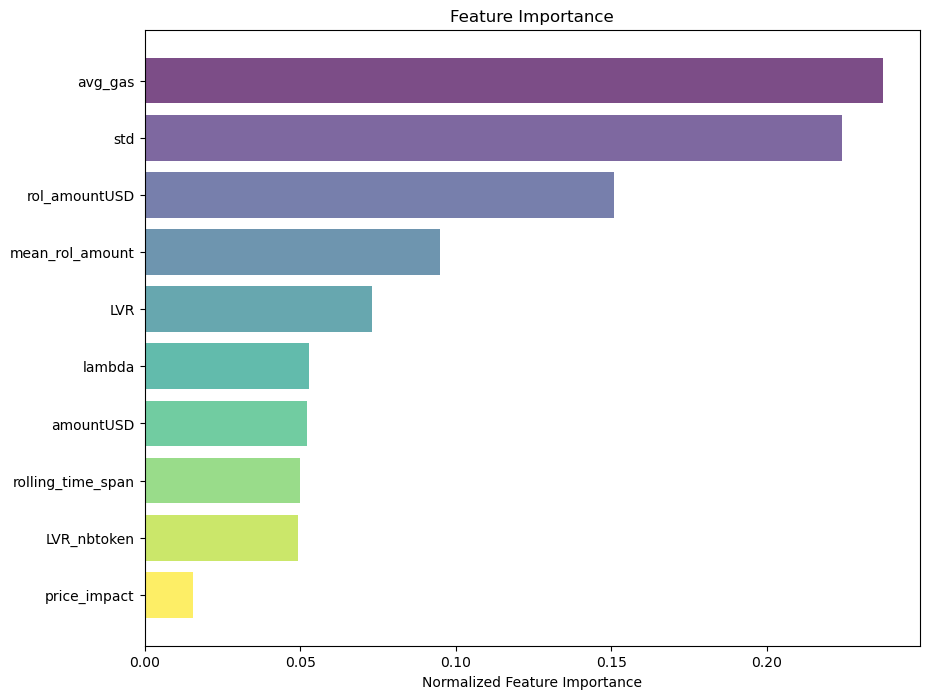

In [483]:
features = list(features_importance_normalized.keys())
importances = list(features_importance_normalized.values())

# Sort features by their importances in descending order
sorted_indices = sorted(range(len(importances)), key=lambda i: importances[i], reverse=False)
sorted_features = [features[i] for i in sorted_indices]
sorted_importances = [importances[i] for i in sorted_indices]

# Use viridis color map
colors = plt.cm.viridis(np.linspace(1, 0, len(features)))

plt.figure(figsize=(10, 8))
plt.barh(sorted_features, sorted_importances, color=colors, alpha=0.7)
plt.xlabel('Normalized Feature Importance')
plt.title('Feature Importance')
plt.show()


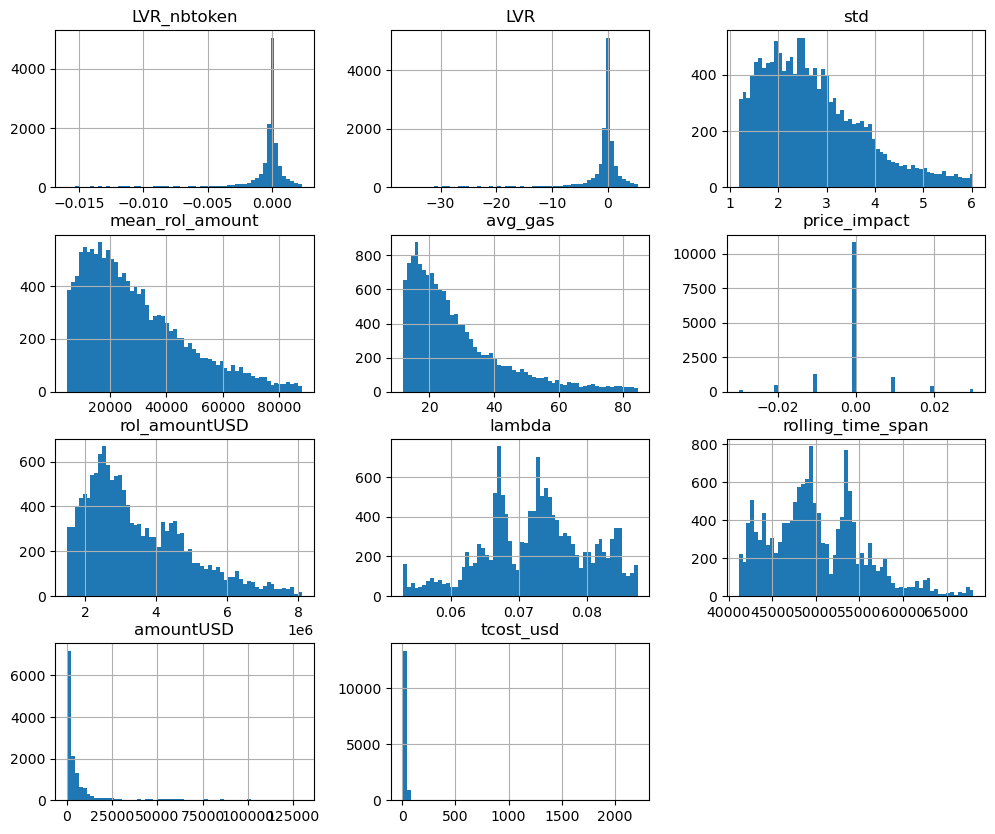

In [484]:
data_filtered[features+[target]].hist(bins=60, figsize=(12, 10))
plt.show()

/var/folders/fn/zk93lv7x5qb0fyk32l1610240000gn/T/ipykernel_26941/3780759548.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_subset['model_fee'] = buy_subset['LVR_zscore'].apply(lambda x: adjusted_sigmoid(x, f_min, f_max, k, x0))
/var/folders/fn/zk93lv7x5qb0fyk32l1610240000gn/T/ipykernel_26941/3780759548.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sell_subset['model_fee'] = -sell_subset['LVR_zscore'].apply(lambda x: adjusted_sigmoid(-x, f_min, f_max, k, x0))
/var/folders/fn/zk93lv7x5qb0fyk3

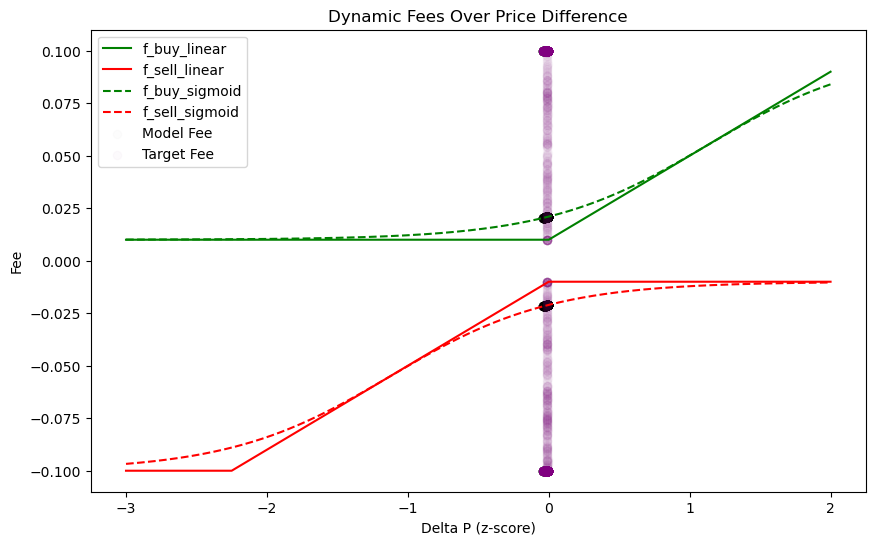

In [492]:
delta_p = pd.DataFrame({'delta_p': np.linspace(-3, 2, 2001)})
f_min = 0.01
f_max = 0.1
w     = 0.04

delta_p['f_buy_linear']  = delta_p['delta_p'].apply(lambda x: min(f_max, f_min + w * max(0, x)))
delta_p['f_sell_linear'] = delta_p['delta_p'].apply(lambda x: min(f_max, f_min - w * min(0, x)))

x0 = (f_max-f_min)/(2*w)  # Adjust x0 as needed based on your understanding of the data
k = 1.75  # Steepness of the curve

delta_p['f_buy_sigmoid'] = delta_p['delta_p'].apply(lambda x: adjusted_sigmoid(x, f_min, f_max, k, x0))
delta_p['f_sell_sigmoid'] = delta_p['delta_p'].apply(lambda x: adjusted_sigmoid(-x, f_min, f_max, k, x0))

plt.figure(figsize=(10, 6))

plt.plot(delta_p['delta_p'], delta_p['f_buy_linear'],  label='f_buy_linear', color='green')
plt.plot(delta_p['delta_p'], -delta_p['f_sell_linear'], label='f_sell_linear', color='red')

plt.plot(delta_p['delta_p'], delta_p['f_buy_sigmoid'],  label='f_buy_sigmoid',  linestyle='--', color='green')
plt.plot(delta_p['delta_p'], -delta_p['f_sell_sigmoid'], label='f_sell_sigmoid', linestyle='--', color='red')

# Segment the data based on 'amount1'
buy_subset = data_filtered[data_filtered['amount1'] < 0]
sell_subset = data_filtered[data_filtered['amount1'] > 0]

## !! the price difference is stationnary because we cans stipulate the the dex and cex price are stationnary wich makes total sense 
# cause they are the same asset and arrbitragers always move to remove the differnce
# Then we dont really need to care of using the zscore also because we will redo a different calibration for a different pair 
# (so we dont need to normalize the time series of the difference)

# Apply the fees
buy_subset['model_fee'] = buy_subset['LVR_zscore'].apply(lambda x: adjusted_sigmoid(x, f_min, f_max, k, x0))
sell_subset['model_fee'] = -sell_subset['LVR_zscore'].apply(lambda x: adjusted_sigmoid(-x, f_min, f_max, k, x0))

buy_subset['target_fee'] = buy_subset['target_fee'].clip(f_min, f_max)
sell_subset['target_fee'] = sell_subset['target_fee'].clip(-f_min, -f_max)

combined_data = pd.concat([buy_subset, sell_subset])
plt.scatter(combined_data['LVR_zscore'], combined_data['model_fee'], alpha=0.01, color='black', label='Model Fee')

plt.scatter(combined_data['LVR_zscore'], combined_data['target_fee'], alpha=0.02, color='purple', label='Target Fee')

plt.xlabel('Delta P (z-score)')
plt.ylabel('Fee')
plt.legend()
plt.title('Dynamic Fees Over Price Difference')
plt.show()

In [488]:
data_filtered

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,LVR_zscore,std,mean_rol_amount,rol_amountUSD,price_impact,rolling_time_span,rolling_trade_count,lambda,target_fee,model_fee
2429,111433.782726,-48.312042,111259.390272,0x675bb023e268dcc43f543620577bcacb73047f08,0xe8cfad4c75a5e1caf939fd80afcf837dde340a69,0xe8cfad4c75a5e1caf939fd80afcf837dde340a69,1.704113e+09,350000,3.100250e+10,3.100250e-08,...,-0.028593,1.220843,57209.149228,5.507805e+06,0.000000,45732.0,2430.0,0.053136,0.401127,0.021520
2430,1000.000000,-0.433470,998.343956,0xdf0944d413f83abeba6bc23891bc183bb9d6a77b,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704113e+09,287782,1.139920e+10,1.139920e-08,...,-0.010142,1.263497,34087.398689,5.503652e+06,0.000000,45744.0,2431.0,0.053144,0.410639,0.021200
2431,-1958.956271,0.850000,1956.690489,0xa24c6e08855a5c6222b6e115bfcf1ce0fb2b9b2c,0xf3de3c0d654fda23dad170f0f320a92172509127,0xa24c6e08855a5c6222b6e115bfcf1ce0fb2b9b2c,1.704113e+09,197384,1.166991e+10,1.166991e-08,...,-0.009354,1.299486,27127.106187,5.505607e+06,0.000000,45756.0,2432.0,0.053151,-0.668999,0.021186
2433,-3070.103918,1.332142,3066.564707,0x7cb828a7b90fa88be0c5cb45ba4646d9be0a28d9,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x7cb828a7b90fa88be0c5cb45ba4646d9be0a28d9,1.704113e+09,267302,1.371250e+10,1.371250e-08,...,-0.009932,1.361286,27346.007153,5.410094e+06,0.000000,45828.0,2434.0,0.053112,-0.037970,0.021196
2434,-35052.500000,15.209639,35012.187455,0xb550c1d0df798dd75971f328170bbb903c606ead,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704113e+09,292041,1.328220e+10,1.328220e-08,...,-0.009492,1.387393,30844.651003,5.438514e+06,0.000000,45840.0,2435.0,0.053120,-0.035285,0.021189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57973,-2475.266618,1.000000,2474.499118,0x2ee140fa48d3f53f8e0bb20cd1fcc11ba7178ec5,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704917e+09,225566,3.165331e+10,3.165331e-08,...,-0.010161,1.590383,16483.813585,2.873990e+06,0.000000,41172.0,3600.0,0.087438,-0.204860,0.021200
57974,2000.000000,-0.807187,1998.382142,0x6bd98e1fc52280c18ffb54e079496134fb267578,0x1111111254eeb25477b68fb85ed929f73a960582,0x1111111254eeb25477b68fb85ed929f73a960582,1.704917e+09,542215,3.075883e+10,3.075883e-08,...,-0.010241,1.572212,16188.800997,2.698884e+06,0.010000,41184.0,3600.0,0.087413,0.355062,0.021202
57978,10126.505524,-4.083839,10114.413356,0xde72c68b645018d928b88c45fc39a995b07153a0,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0xfe9e7931e55c514c33d489c88582fa36e84bd8e3,1.704917e+09,273680,3.787198e+10,3.787198e-08,...,-0.009103,1.504438,22596.820838,2.786992e+06,-0.009999,41172.0,3600.0,0.087438,0.231379,0.021182
57979,-9883.938049,3.990000,9877.063603,0xe7f525dd1bc6d748ae4d7f21d31e54741e05e110,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704917e+09,234810,3.523674e+10,3.523674e-08,...,-0.009604,1.466608,23484.575707,2.747455e+06,-0.009999,41208.0,3600.0,0.087362,-0.102386,0.021191


In [ ]:
## change the buy and sell fee for the regression
## add the arbitrager pnl as a afeature to punish
## finish the computation

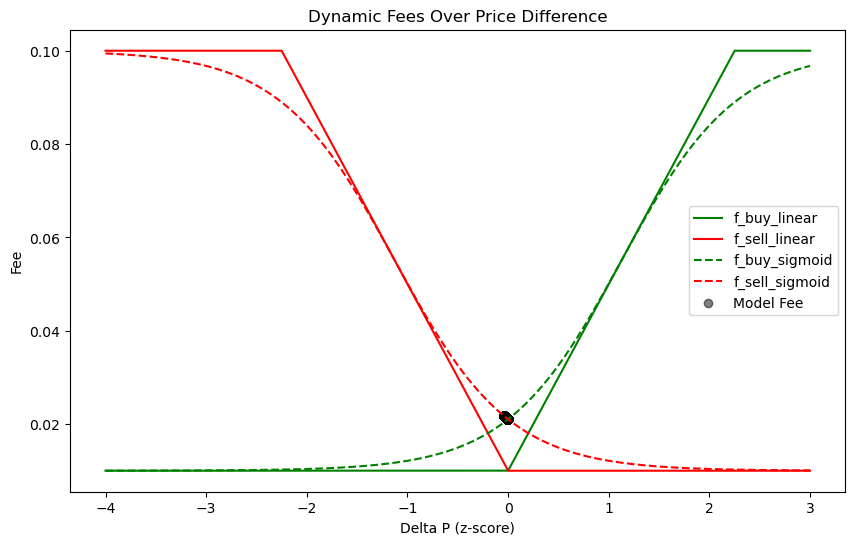

In [497]:
delta_p = pd.DataFrame({'delta_p': np.linspace(-4, 3, 2001)})
f_min = 0.01
f_max = 0.1
w     = 0.04

def global_sigmoid(x, f_min, f_max, k=1, x0=0):
    if x > 0:
        return adjusted_sigmoid(x, f_min, f_max, k, x0)
    else:
        return adjusted_sigmoid(-x, f_min, f_max, k, x0)

delta_p['f_buy_linear']  = delta_p['delta_p'].apply(lambda x: min(f_max, f_min + w * max(0, x)))
delta_p['f_sell_linear'] = delta_p['delta_p'].apply(lambda x: min(f_max, f_min - w * min(0, x)))

x0 = (f_max-f_min)/(2*w)  # Adjust x0 as needed based on your understanding of the data
k = 1.75  # Steepness of the curve

delta_p['f_buy_sigmoid'] = delta_p['delta_p'].apply(lambda x: adjusted_sigmoid(x, f_min, f_max, k, x0))
delta_p['f_sell_sigmoid'] = delta_p['delta_p'].apply(lambda x: adjusted_sigmoid(-x, f_min, f_max, k, x0))

plt.figure(figsize=(10, 6))

plt.plot(delta_p['delta_p'], delta_p['f_buy_linear'],  label='f_buy_linear', color='green')
plt.plot(delta_p['delta_p'], delta_p['f_sell_linear'], label='f_sell_linear', color='red')

plt.plot(delta_p['delta_p'], delta_p['f_buy_sigmoid'],  label='f_buy_sigmoid',  linestyle='--', color='green')
plt.plot(delta_p['delta_p'], delta_p['f_sell_sigmoid'], label='f_sell_sigmoid', linestyle='--', color='red')

data_filtered['model_fee'] = data_filtered['LVR_zscore'].apply(lambda x: global_sigmoid(x, f_min, f_max, k, x0))
plt.scatter(data_filtered['LVR_zscore'], data_filtered['model_fee'], alpha=0.5, color='black', label='Model Fee')

plt.xlabel('Delta P (z-score)')
plt.ylabel('Fee')
plt.legend()
plt.title('Dynamic Fees Over Price Difference')
plt.show()


In [502]:
def calculate_markout(d, v, f, p):
    m = d * v * (f - p)
    return m

combined_data['target_fee_usd'] = combined_data['target_fee'] * combined_data['amount0']

metrics = combined_data.resample('1Min', on='time_dex').agg({
    'price_dex'           : 'ohlc',
    'amount0'             : 'sum',
    'amount1'             : 'sum',
    'amountUSD'           : 'sum',
    'LVR'                 : 'sum',
    'impermanent_loss'    : 'sum',
    'tcost_usd'           : 'sum',
    'target_fee_usd'      : 'sum',
})
metrics.columns = metrics.columns.droplevel(0)
metrics = metrics.rename(columns={'amountUSD': 'volumeUSD'})
metrics['1m_volumeUSD'] = metrics['volumeUSD'].rolling(window=60).sum()

metrics['future_close'] = metrics['close'].shift(-60)
metrics = metrics.dropna()

metrics['markout'] = metrics.apply(lambda x: calculate_markout(d=np.sign(x['amount0']), v=x['volumeUSD'], f=x['future_close'], p=x['close']), axis=1)

pool_fee_rate = 0.05/100

metrics['trade_direction'] = np.sign(metrics['amount0'])
metrics['cfee'] = pool_fee_rate * metrics['volumeUSD']
metrics['dfee'] = metrics['target_fee_usd'] * metrics['volumeUSD']

metrics['cpnl'] = metrics['close'].shift(-1) - metrics['close'] + metrics['cfee'].abs()
metrics['dpnl'] = metrics['close'].shift(-1) - metrics['close'] + metrics['dfee'].abs()

metrics['cfee_cumul'] = metrics['cfee'].cumsum()
metrics['dfee_cumul'] = metrics['dfee'].cumsum()
metrics['avg_7m_cfee'] = (metrics['volumeUSD'] * pool_fee_rate).rolling(window=7).mean()

metrics['cpnl_5m_positive'] = metrics['cpnl'].rolling(window=5).apply(lambda x: np.sum(x[x>0]))
metrics['cpnl_5m_negative'] = metrics['cpnl'].rolling(window=5).apply(lambda x: np.sum(x[x<0]))
# Calculate a 7 min ma of percent toxic flow:
metrics['c%_toxic_flow_ma_7m'] = (metrics['cpnl_5m_negative'] / (metrics['cpnl_5m_negative'] + metrics['cpnl_5m_positive'])).rolling(window=7).mean()

metrics['dpnl_5m_positive'] = metrics['dpnl'].rolling(window=5).apply(lambda x: np.sum(x[x>0]))
metrics['dpnl_5m_negative'] = metrics['dpnl'].rolling(window=5).apply(lambda x: np.sum(x[x<0]))
# Calculate a 7 min ma of percent toxic flow:
metrics['d%_toxic_flow_ma_7m'] = (metrics['dpnl_5m_negative'] / (metrics['dpnl_5m_negative'] + metrics['dpnl_5m_positive'])).rolling(window=7).mean()

metrics.dropna()

KeyError: "Column(s) ['combined_fee'] do not exist"

In [ ]:
# 'origin','sender'
data_filtered[['arb_pnl', 'origin']].groupby('origin').sum()

KeyError: "['arb_pnl'] not in index"

In [ ]:
tmp = (data[['LVR_pnl_percent', 'sender']].groupby('sender').sum()>100).reset_index()
abritrageur_address_list = tmp[tmp['LVR_pnl_percent'] == True].sender.values
print(len(abritrageur_address_list))
filtered_data = data[data['sender'].isin(abritrageur_address_list)]
t = data[['LVR_pnl_percent', 'sender']].groupby('sender').sum().apply(lambda x : sigmoid(x))

201


/Users/armandmorin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# methodology:
# Take a rolling windows of the past 1 million tx for instance
# Perform all the signle trades analysis, in term of pnl anf LVR percent
# Aggregate the metrics to get the trader perfs 
# Charge the fee per trader

def fee_pnl(LVR_pnl_percent):
    # output is in 100%
    coef = 1
    return sigmoid(LVR_pnl_percent / 250) * coef

def fee_base(LVR_zscore):
    # output is in 100%
    base_pool_fee = 0.05
    coef = 1.03
    return coef * sigmoid(base_pool_fee + LVR_zscore * 0.03)

agg_sender = data[['LVR_pnl_percent', 'LVR_zscore', 'sender']].groupby('sender').sum()
agg_origin = data[['LVR_pnl_percent', 'LVR_zscore', 'origin']].groupby('origin').sum()
agg_recipient = data[['LVR_pnl_percent', 'LVR_zscore', 'recipient']].groupby('recipient').sum()

dico_percent = {}
dico_zscore = {}

for df in [agg_sender, agg_origin, agg_recipient]:
    for address, lvr_percent, lvr_zscore in zip(df.index, df['LVR_pnl_percent'], df['LVR_zscore']):
        if address in dico_percent:
            dico_percent[address] += lvr_percent
            dico_zscore[address] += lvr_zscore
        else:
            dico_percent[address] = lvr_percent
            dico_zscore[address] = lvr_zscore


# filter addresses trading with positive LVR return 
dic_base_fee = {address: fee_base(LVR_zscore) for address, LVR_zscore in dico_zscore.items() if LVR_zscore > 0}

dic_fee       = {address: fee_pnl(LVR_pnl_percent) for address, LVR_pnl_percent in dico_percent.items() if LVR_pnl_percent > 0 }

merged_dict = {key: dic_fee.get(key, 0) + dic_base_fee.get(key, 0) for key in set(dic_fee) | set(dic_base_fee)}

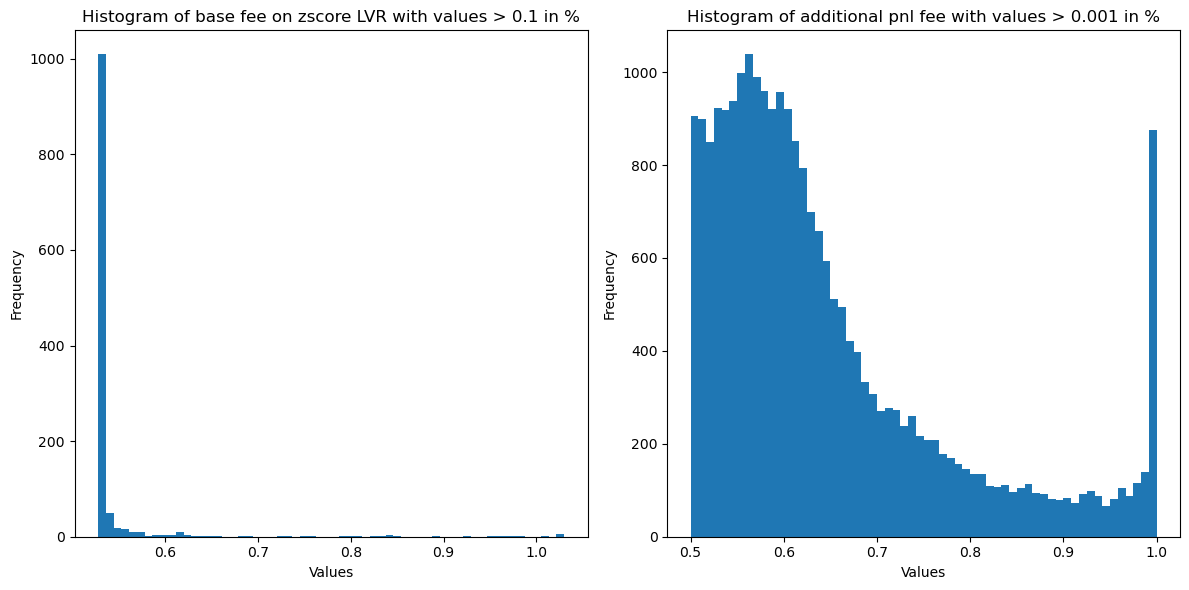

In [ ]:
import matplotlib.pyplot as plt

# Filter values greater than threshold in %
threshold_base = 0.1
threshold_fees = 0.001
filtered_base_values = [value for value in dic_base_fee.values() if value > threshold_base]
filtered_fee_values = [value for value in dic_fee.values() if value > threshold_fees]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.hist(filtered_base_values, bins=60)
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')
ax1.set_title(f'Histogram of base fee on zscore LVR with values > {threshold_base} in %')

ax2.hist(filtered_fee_values, bins=60)
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')
ax2.set_title(f'Histogram of additional pnl fee with values > {threshold_fees} in %')

plt.tight_layout()
plt.show()


In [ ]:
please = pd.DataFrame.from_dict(merged_dict, orient='index', columns=['fees'])
please = please.reset_index().rename(columns={'index': 'address'}).sort_values(by='fees', ascending=False)

merged_data = data.merge(please.rename(columns={'fees' : 'f1'}), left_on='sender', how='left', right_on='address')
merged_data = merged_data.merge(please.rename(columns={'fees' : 'f2'}), left_on='origin', how='left', right_on='address')
merged_data = merged_data.merge(please.rename(columns={'fees' : 'f3'}), left_on='recipient', how='left', right_on='address')

merged_data[['f1', 'f2', 'f3']] = merged_data[['f1', 'f2', 'f3']].fillna(0).clip(lower=0.05)

merged_data['mean_fee'] = merged_data[['f1', 'f2', 'f3']].mean(axis=1) 
#merged_data['max_fee']  = merged_data[['f1', 'f2', 'f3']].max(axis=1) 

merged_data = merged_data.drop(columns=['address_x', 'address_y', 'address', 'f1', 'f2', 'f3']).fillna(0.5)

merged_data

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,LVR_nbtoken,LVR_pnl_percent,LVR_zscore,std,mean_rol_amount,volumeUSD,price_impact,lambda,target_fee,mean_fee
0,18096.796543,-7.930474,18076.269412,0xe743a49f04f2f77eb2d3b753ae3ad599de8cea84,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x4fd39c9e151e50580779bd04b1f7ecc310079fd3,1.704067e+09,427523,1.358341e+10,1.358341e-08,...,-0.001082,31.058511,-0.012213,0.500000,0.500000,5.000000e-01,0.000000,0.000000,0.499817,0.366667
1,700.000000,-0.306764,699.212694,0xa1179a0b94e53ee82b77c6d24c2cf67a656c2503,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704067e+09,312000,1.438341e+10,1.438341e-08,...,-0.000042,29.667895,-0.010061,0.500000,0.500000,5.000000e-01,0.000100,0.000000,0.496340,0.209878
2,25000.000000,-10.955150,24971.093893,0x9b4306e7b6ede125b5e8cac309ffb58af5eed6f0,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704067e+09,223193,1.259051e+10,1.259051e-08,...,-0.007604,158.297330,-0.025702,0.500000,0.500000,5.000000e-01,0.000000,0.125000,0.499936,1.175693
3,767.722283,-0.336412,766.824534,0xc10527cdbc055b7f9a8a4ad765b287190c861c51,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704067e+09,247124,1.230578e+10,1.230578e-08,...,-0.000233,157.418365,-0.010458,0.500000,0.500000,5.000000e-01,0.000000,0.111111,0.497738,0.906057
4,170.905965,-0.074890,170.706032,0xf468072ca8f81e11655c252a37317e814b24872b,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0xa9cffe466ba8a72707d1104de239c9ab477e2493,1.704067e+09,2673946,1.443436e+10,1.443436e-08,...,-0.000018,1.747092,-0.010011,0.500000,0.500000,5.000000e-01,0.000100,0.083333,0.373844,0.050000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,-2062.694719,0.800000,2065.676196,0xca74f404e0c7bfa35b13b511097df966d5a65597,0x1111111254eeb25477b68fb85ed929f73a960582,0x1111111254eeb25477b68fb85ed929f73a960582,1.704932e+09,403756,5.626490e+10,5.626490e-08,...,-0.000816,260.387510,-0.011884,7.507411,38686.836319,6.724595e+06,0.000000,0.111152,0.507092,1.000000
59996,-3953.442238,1.533426,3959.304818,0x475d2c6f6a46a83d1781e61500d1c540f85fd721,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0x475d2c6f6a46a83d1781e61500d1c540f85fd721,1.704932e+09,248525,5.216118e+10,5.216118e-08,...,-0.001440,241.379868,-0.013343,7.453936,38555.229368,6.662888e+06,-0.000200,0.111152,0.502112,0.915576
59997,-9584.192801,3.717716,9598.772684,0xeef68d213fbbf6f01235a6c1318f82a1692c01de,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0xeef68d213fbbf6f01235a6c1318f82a1692c01de,1.704932e+09,341150,4.985426e+10,4.985426e-08,...,-0.001753,121.182189,-0.014075,7.403159,38889.495677,6.668813e+06,0.000600,0.111111,0.501142,0.598821
59998,50010.837140,-19.375430,50056.125466,0xe4e968b3abe7123f18b318e8ad17ce3826b5cff6,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704932e+09,332676,4.989490e+10,4.989490e-08,...,0.033442,445.340477,0.068279,7.393779,43395.056279,6.686023e+06,-0.001299,0.111029,0.499786,0.494755


In [ ]:
(merged_data['mean_fee'] * merged_data['amountUSD']/100).sum()

29646230.103912454

In [ ]:
merged_data['LVR'].sum()

660046.1473910192